# Problem Formulation

The problem at hand is to predict the outcome of a specific speed dating seccion based on the profiles of the two participants in such session. The input for the model will be tabular data containing attributes such as age, gender, income, etc. This data is both categorical and continuous, further processing will be conducting to process these different data types. 

The output of the model will be a discrete prediction of the outcome of the speed dating session being either a 1 (successful) or 2(unsuccessful). This a classificaiton problem and the required data mining fuction.

The main challenge presented by this problem is dealing with the imbalance in the dataset and the large amount of missing vlaues. To handle the imbalance issue sampling techniques and or data augmentation. To handle the missing vlaues different imputation methods will be explored. 

The impact of this problem, is to help individuals better find dating partners and for dating companies to find trends that may indicate good matches. 


The ideal solution to this problem is a model that can correctly predict the outcome of a speed dating session with a high accuracy while maintaining a high degree of generalizability. The model must be genrilizable so that it can not only work with speed dating but other dating applicaitons.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from pprint import pprint
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Oct 23 06:16:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
data = pd.read_csv('/content/gdrive/MyDrive/train_A2.csv')
data_test = pd.read_csv('/content/gdrive/MyDrive/test_A2.csv')
data.shape

(5909, 192)

In [ ]:
data.head()

,gender,idg,condtn,wave,round,position,positin1,order,partner,pid,...,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3,id
0,0,3,2,14,18,2,2.0,14,12,372.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2583
1,1,14,1,3,10,2,NaN,8,8,63.0,...,8.0,8.0,7.0,8.0,NaN,NaN,NaN,NaN,NaN,6830
2,1,14,1,13,10,8,8.0,10,10,331.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4840
3,1,38,2,9,20,18,13.0,6,7,200.0,...,9.0,8.0,8.0,6.0,NaN,NaN,NaN,NaN,NaN,5508
4,1,24,2,14,20,6,6.0,20,17,357.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4828


In [ ]:
print(data.columns)

Index(['gender', 'idg', 'condtn', 'wave', 'round', 'position', 'positin1',
       'order', 'partner', 'pid',
       ...
       'sinc3_3', 'intel3_3', 'fun3_3', 'amb3_3', 'attr5_3', 'sinc5_3',
       'intel5_3', 'fun5_3', 'amb5_3', 'id'],
      dtype='object', length=192)


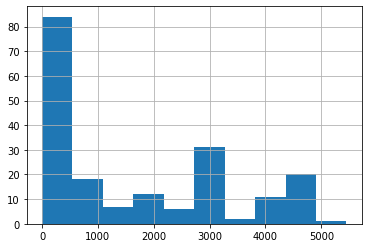

In [ ]:
data.isnull().sum().hist()

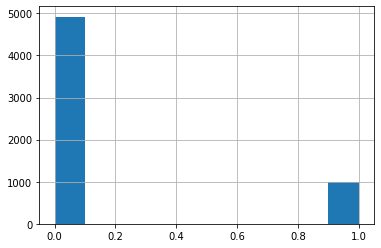

In [ ]:
data['match'].hist()

In [ ]:
# if you haven't installed xgboost on your system, uncomment the line below
!pip install xgboost
# if you haven't installed bayesian-optimization on your system, uncomment the line below
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100 kB 7.9 MB/s 


In [ ]:
x = data.drop('match', axis=1)
features_numeric = list(x.select_dtypes(include=['float64']))
features_categorical = list(x.select_dtypes(include=['object']))
y = data['match']

In [ ]:
print(features_categorical)

['field', 'undergra', 'mn_sat', 'tuition', 'from', 'zipcode', 'income', 'career']


In [ ]:
# All required lybrary for this project
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost.sklearn import XGBClassifier
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.model_selection import StratifiedKFold
from skopt.space import Real, Categorical, Integer
from skopt import BayesSearchCV
from scipy.stats import randint as sp_randInt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
np.random.seed(0)

# the following pipeline is the standard for all following trails, the comments
# in this cell will apply for all following trails in cases where nothing changes

transformer_numeric = Pipeline( # transforms for numeric values in dataset
    steps=[
        ('imputer', SimpleImputer(strategy='median')), # missing value replacment with median value as the defualt
        ('scaler', StandardScaler())] # Standardize the feature set by removing the mean and scaling to unit variance.
)

transformer_categorical = Pipeline( # transforms for categorical values in dataset
    steps=[
        # missing value replacment with a constant value as the defualt
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')), 
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
        # encode all the categorical values with binary values
    ]
)

# Apply the above numeric and categgorical transformations to the whole dataset(dataframe)
preprocessor = ColumnTransformer( 
    transformers=[
        ('num', transformer_numeric, features_numeric),
        ('cat', transformer_categorical, features_categorical)
    ]
)

# Create a sklearn pipeline and complie the required steps
full_pipline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('my_classifier', XGBClassifier( # XGBoost the claddifier being used in this pipeline
            objective='binary:logistic', seed=1))
    ]
)

# prepare parameters and their possible values for the following gridsearch
param_grid = {
    'preprocessor__num__imputer__strategy': ['mean'],
    'my_classifier__n_estimators': [10, 20, 100],
    'my_classifier__max_depth':[10, 20]
}

# Gridsearch with 5 k-fold validation
grid_search = GridSearchCV(
    full_pipline, param_grid, cv=5, verbose=3, n_jobs=1, 
    scoring='roc_auc',return_train_score=True)

grid_search.fit(x, y)

print('best score {}'.format(grid_search.best_score_))
print('best score {}'.format(grid_search.best_params_))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END my_classifier__max_depth=10, my_classifier__n_estimators=10, preprocessor__num__imputer__strategy=mean;, score=(train=0.994, test=0.855) total time=   3.2s
[CV 2/5] END my_classifier__max_depth=10, my_classifier__n_estimators=10, preprocessor__num__imputer__strategy=mean;, score=(train=0.992, test=0.852) total time=   2.1s
[CV 3/5] END my_classifier__max_depth=10, my_classifier__n_estimators=10, preprocessor__num__imputer__strategy=mean;, score=(train=0.994, test=0.833) total time=   1.1s
[CV 4/5] END my_classifier__max_depth=10, my_classifier__n_estimators=10, preprocessor__num__imputer__strategy=mean;, score=(train=0.990, test=0.828) total time=   1.2s
[CV 5/5] END my_classifier__max_depth=10, my_classifier__n_estimators=10, preprocessor__num__imputer__strategy=mean;, score=(train=0.989, test=0.833) total time=   1.1s
[CV 1/5] END my_classifier__max_depth=10, my_classifier__n_estimators=20, preprocessor__num__im

In [ ]:
df_results = pd.DataFrame(grid_search.cv_results_)
print(df_results['mean_train_score'].tolist)
print(df_results['mean_test_score'].tolist)

<bound method IndexOpsMixin.tolist of 0    0.991696
1    0.998603
2    1.000000
3    0.998035
4    0.999912
5    1.000000
Name: mean_train_score, dtype: float64>
<bound method IndexOpsMixin.tolist of 0    0.840206
1    0.853616
2    0.878940
3    0.831784
4    0.853915
5    0.878682
Name: mean_test_score, dtype: float64>


# Trial 1
 
reason for change?
 
To build on the work done in trial 0, and to address the issue of missing values a KNN imputer will be used in trail 1. In trial 0, missing vlaues were replaced with either the mean value for numeric values or constants for categorical values. KNN imputer works by replacing missing values with the mean of the missing values n nearest neighbors. This will create a more representative replacement value.
 
*Note, applying a KNNImputer to categorical features presents an issue. When you one hot encoded your categorical data, the missing values will be encoded into new binary values and thus no longer be missing values. For categorical values the most frequent imputer method will be used to hopefully generate better results than replacing with constant.  
 
expected outcome?
 
I expect the performance of the model to improve, as the replacement of missing values using KNN imputation should generate a dataset that is more representative of the relationships between features. The overfitting problem will most likely still be present as the issue of imbalance in the dataset has not yet been addressed. 


In [ ]:
np.random.seed(0)

transformer_numeric = Pipeline(
    steps=[
        ('imputer', KNNImputer(n_neighbors=2)), #KNNImputer using n = 2 for nearest neighbours 
        ('scaler', StandardScaler())]
)

transformer_categorical = Pipeline(
    steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore')),
        ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')) # change to most frequent replacement instead of constant
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', transformer_numeric, features_numeric),
        ('cat', transformer_categorical, features_categorical)
    ]
)

full_pipline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('my_classifier', XGBClassifier(
            objective='binary:logistic', seed=1))
    ]
)

param_grid = {
    'my_classifier__n_estimators': [10, 20, 100],
    'my_classifier__max_depth':[10, 20]
}

grid_search = GridSearchCV(
    full_pipline, param_grid, cv=5, verbose=3, n_jobs=1, 
    scoring='roc_auc',return_train_score=True)

grid_search.fit(x, y)

print('best score {}'.format(grid_search.best_score_))
print('best score {}'.format(grid_search.best_params_))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END my_classifier__max_depth=10, my_classifier__n_estimators=10;, score=(train=0.994, test=0.830) total time=  22.5s
[CV 2/5] END my_classifier__max_depth=10, my_classifier__n_estimators=10;, score=(train=0.995, test=0.828) total time=  24.2s
[CV 3/5] END my_classifier__max_depth=10, my_classifier__n_estimators=10;, score=(train=0.995, test=0.812) total time=  25.6s
[CV 4/5] END my_classifier__max_depth=10, my_classifier__n_estimators=10;, score=(train=0.988, test=0.824) total time=  25.0s
[CV 5/5] END my_classifier__max_depth=10, my_classifier__n_estimators=10;, score=(train=0.989, test=0.826) total time=  23.1s
[CV 1/5] END my_classifier__max_depth=10, my_classifier__n_estimators=20;, score=(train=0.999, test=0.848) total time=  26.6s
[CV 2/5] END my_classifier__max_depth=10, my_classifier__n_estimators=20;, score=(train=1.000, test=0.841) total time=  27.0s
[CV 3/5] END my_classifier__max_depth=10, my_classifier__n

In [ ]:
df_results = pd.DataFrame(grid_search.cv_results_)
print(df_results['mean_train_score'].tolist)
print(df_results['mean_test_score'].tolist)

<bound method IndexOpsMixin.tolist of 0    0.992249
1    0.999098
2    1.000000
3    0.998472
4    0.999947
5    1.000000
Name: mean_train_score, dtype: float64>
<bound method IndexOpsMixin.tolist of 0    0.823932
1    0.842706
2    0.867999
3    0.816920
4    0.835567
5    0.867469
Name: mean_test_score, dtype: float64>


###thoughts and observations for trial 1

Unexpectedly the performance did not improve, there was a very slight decrease in performance. This technique of imputation is a lot more computationally expensive although I do think it will still provide performance improvements with further changes. There is still signs of overfitting with the near perfect training accuracy and worse validation/test accuracy. 

###plan for trial 2

The next plan of attack is to address the imbalance in the training data by implementing SMOTE. I will continue to use the KNNImputer as i still believe it is a more accurate way to fill missing values. I will compare the results using SMOTE with KNNImputer and SMOTE with simple imputation to see if the KNNimputer really does not increase the performance of the model. 



# Trial 2
 
reason for change?

The used classifier XGBoost is a boosting algorithm which applied regularization techniques to reduce overfitting, although there is some slight overfitting observed. The observation is that there is near perfect training accuracy, while lesser validation/test accuracy. To further help with overfitting, the issue of imbalance in the dataset needs to be addressed. Synthetic Minority Oversmapling Technique (SMOTE) is a technique that works to increase the number of instances of the minority class in an imbalanced dataset.

Stratisfied k fold cross validaiton will be used to maintain this rebalance in class representaiton throughout all folds. 

The model will be trained once with KNNImputer and once with simple imputation, to see if if the KNNimputer really does not increase the perforamnce of the model. 

expected outcome?

By creating a more balanced dataset the model should be able to have increased test accuracy as the training rounds are now seeing more occasions of the minority class. 


In [ ]:
np.random.seed(0)

transformer_numeric = Pipeline(
    steps=[
        ('imputer', KNNImputer(n_neighbors=2)),
        ('scaler', StandardScaler())]
)

transformer_categorical = Pipeline(
    steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore')),
        ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing'))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', transformer_numeric, features_numeric),
        ('cat', transformer_categorical, features_categorical)
    ]
)

full_pipline = imbpipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('smote',SMOTE(random_state=11)), #add SMOTE to the pipeline steps
        ('my_classifier', XGBClassifier(
            objective='binary:logistic', seed=1))
    ]
)

stratisfied_kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=11)
                                       

param_grid = {
    'my_classifier__n_estimators': [10, 20, 100],
    'my_classifier__max_depth':[10, 20]
}

grid_search = GridSearchCV(
    full_pipline, param_grid, cv=stratisfied_kfold, verbose=3, n_jobs=1, 
    scoring='roc_auc',return_train_score=True)

grid_search.fit(x, y)

print('best score {}'.format(grid_search.best_score_))
print('best score {}'.format(grid_search.best_params_))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END my_classifier__max_depth=10, my_classifier__n_estimators=10;, score=(train=0.969, test=0.814) total time=  26.9s
[CV 2/5] END my_classifier__max_depth=10, my_classifier__n_estimators=10;, score=(train=0.971, test=0.821) total time=  27.1s
[CV 3/5] END my_classifier__max_depth=10, my_classifier__n_estimators=10;, score=(train=0.973, test=0.844) total time=  28.3s
[CV 4/5] END my_classifier__max_depth=10, my_classifier__n_estimators=10;, score=(train=0.964, test=0.829) total time=  26.0s
[CV 5/5] END my_classifier__max_depth=10, my_classifier__n_estimators=10;, score=(train=0.973, test=0.833) total time=  25.6s
[CV 1/5] END my_classifier__max_depth=10, my_classifier__n_estimators=20;, score=(train=0.993, test=0.829) total time=  30.0s
[CV 2/5] END my_classifier__max_depth=10, my_classifier__n_estimators=20;, score=(train=0.995, test=0.840) total time=  30.2s
[CV 3/5] END my_classifier__max_depth=10, my_classifier__n

In [ ]:
df_results = pd.DataFrame(grid_search.cv_results_)
print(df_results['mean_train_score'].tolist)
print(df_results['mean_test_score'].tolist)

<bound method IndexOpsMixin.tolist of 0    0.970011
1    0.993531
2    1.000000
3    0.995219
4    0.999641
5    1.000000
Name: mean_train_score, dtype: float64>
<bound method IndexOpsMixin.tolist of 0    0.828154
1    0.844536
2    0.867373
3    0.824090
4    0.840403
5    0.864614
Name: mean_test_score, dtype: float64>


In [ ]:
np.random.seed(0)

transformer_numeric = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')), # now using simple imputation to see if KNN imputation really does not perform any better
        ('scaler', StandardScaler())]
)

transformer_categorical = Pipeline(
    steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore')),
        ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing'))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', transformer_numeric, features_numeric),
        ('cat', transformer_categorical, features_categorical)
    ]
)

# need to use imblearn pipeline, since SMOTE doesn’t have a ‘fit_transform’ method
# thus cannot use it with ‘Scikit-Learn’ pipeline.

full_pipline = imbpipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('smote',SMOTE(random_state=11)),
        ('my_classifier', XGBClassifier(
            objective='binary:logistic', seed=1))
    ]
)

stratisfied_kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=11)
                                       
param_grid = {
    'preprocessor__num__imputer__strategy': ['mean'],
    'my_classifier__n_estimators': [10, 20, 100],
    'my_classifier__max_depth':[10, 20]
}

grid_search_final_simple = GridSearchCV(
    full_pipline, param_grid, cv=stratisfied_kfold, verbose=3, n_jobs=1, 
    scoring='roc_auc',return_train_score=True)

grid_search_final_simple.fit(x, y)

print('best score {}'.format(grid_search_final_simple.best_score_))
print('best score {}'.format(grid_search_final_simple.best_params_))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END my_classifier__max_depth=10, my_classifier__n_estimators=10, preprocessor__num__imputer__strategy=mean;, score=(train=0.975, test=0.831) total time=   2.7s
[CV 2/5] END my_classifier__max_depth=10, my_classifier__n_estimators=10, preprocessor__num__imputer__strategy=mean;, score=(train=0.975, test=0.832) total time=   2.7s
[CV 3/5] END my_classifier__max_depth=10, my_classifier__n_estimators=10, preprocessor__num__imputer__strategy=mean;, score=(train=0.972, test=0.866) total time=   2.6s
[CV 4/5] END my_classifier__max_depth=10, my_classifier__n_estimators=10, preprocessor__num__imputer__strategy=mean;, score=(train=0.970, test=0.846) total time=   2.7s
[CV 5/5] END my_classifier__max_depth=10, my_classifier__n_estimators=10, preprocessor__num__imputer__strategy=mean;, score=(train=0.972, test=0.844) total time=   2.7s
[CV 1/5] END my_classifier__max_depth=10, my_classifier__n_estimators=20, preprocessor__num__im

In [ ]:
df_results = pd.DataFrame(grid_search.cv_results_)
print(df_results['mean_train_score'].tolist)
print(df_results['mean_test_score'].tolist)

<bound method IndexOpsMixin.tolist of 0    0.972818
1    0.992497
2    1.000000
3    0.996173
4    0.999778
5    1.000000
Name: mean_train_score, dtype: float64>
<bound method IndexOpsMixin.tolist of 0    0.843878
1    0.861325
2    0.879595
3    0.827823
4    0.848299
5    0.876066
Name: mean_test_score, dtype: float64>


###thoughts and observations for trial 2

Simple imputation 
- trial 0: best score 0.8789401909943632 (no SMOTE)
- trial 2: best score 0.8795950960492078 (SMOTE)

KNNimputer 
- trial 0: best score 0.8679986418483383 (no SMOTE)
- trial 2: best score 0.8673728572952948 (SMOTE)

As you can see the SMOTE method for balancing the dataset Unexpectedly does not improve the test accuracy by any significant amount. The second observation is that indeed simple imputation method produces better results than the KNNimputer method. Moving forward the simple imputation method will be used. The very slight improvement from the addition of SMOTE is still relevant and thus will be continuously used in the following trials.

###plan for trial 3

The next two trials will be used to test the effect of both random search and bayesian search on the performance of the model and associated computation time. To be consistent and best see the effects of the different search algorithms the same configurations and models will be used 

# Trial 3
 
reason for change?

Testing the methods for hyper parameter tuning is a crucial aspect of the processes and thus must be conducted. In this trial bayesian search will be used.Bayesian optimization utilizes the results from the previous step to decide which hyper parameter combination to evaluate next. The major difference between Bayesian optimization and grid  search is that grid search considers each hyper parameter combination independently, while Bayesian optimization is dependent on the previous evaluation results.


expected outcome?

The bayesian search should produce similar i results as the grid search used in previous trials, although in less computation time. Bayesian search, searches a distribution rather than a set of parameters, thus the search will for example search max depth's within the range of 10 - 20, where as in grid search only 10 and 20 were searched. 




In [ ]:

np.random.seed(0)

transformer_numeric = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')), #resort back to simple imputation
        ('scaler', StandardScaler())]
)

transformer_categorical = Pipeline(
    steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore')),
        ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing'))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', transformer_numeric, features_numeric),
        ('cat', transformer_categorical, features_categorical)
    ]
)

# need to use imblearn pipeline, since SMOTE doesn’t have a ‘fit_transform’ method
# thus cannot use it with ‘Scikit-Learn’ pipeline.

full_pipline = imbpipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('smote',SMOTE(random_state=11)),
        ('my_classifier', XGBClassifier(
            objective='binary:logistic', seed=1))
    ]
)

stratisfied_kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=11)
                                       
param_grid = {
    'preprocessor__num__imputer__strategy': Categorical(['mean']),
    'my_classifier__n_estimators': Integer(10,100),
    'my_classifier__max_depth': Integer(10,20) #,prior='log-uniform')
}


# but rather a fixed number of parameter settings is sampled from the specified distributions. The number of parameter settings that are tried is given by n_iter.
# With Bayes search a fixed number of parameters are sampled from a specified distribution.
# n_iter is the parameter set to the number of parameter settings tried. 
# in previous trials 30 fits were used so i will use n_iter to 6. 

bayes_search = BayesSearchCV(
    full_pipline, param_grid, cv=stratisfied_kfold, verbose=3, n_jobs=1,n_iter=10, 
    scoring='roc_auc',return_train_score=True)

bayes_search.fit(x, y)

print('best score {}'.format(bayes_search.best_score_))
print('best score {}'.format(bayes_search.best_params_))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END my_classifier__max_depth=31, my_classifier__n_estimators=71, preprocessor__num__imputer__strategy=mean;, score=(train=1.000, test=0.876) total time=  21.7s
[CV 2/5] END my_classifier__max_depth=31, my_classifier__n_estimators=71, preprocessor__num__imputer__strategy=mean;, score=(train=1.000, test=0.868) total time=  21.1s
[CV 3/5] END my_classifier__max_depth=31, my_classifier__n_estimators=71, preprocessor__num__imputer__strategy=mean;, score=(train=1.000, test=0.887) total time=  20.8s
[CV 4/5] END my_classifier__max_depth=31, my_classifier__n_estimators=71, preprocessor__num__imputer__strategy=mean;, score=(train=1.000, test=0.870) total time=  21.3s
[CV 5/5] END my_classifier__max_depth=31, my_classifier__n_estimators=71, preprocessor__num__imputer__strategy=mean;, score=(train=1.000, test=0.872) total time=  20.8s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END my_classifier__max_depth

###thoughts and observations for trial 3

- trial 2: best score 0.8795950960492078 
{'my_classifier__max_depth': 10, 'my_classifier__n_estimators': 100, 'preprocessor__num__imputer__strategy': 'mean'}
- trial 3: best score 0.8763575240764953
('my_classifier__max_depth', 14), ('my_classifier__n_estimators', 91), ('preprocessor__num__imputer__strategy', 'mean')]

This trial went as expected, using the same model and preprocessing configurations as trial 2 the bayesian search found similar optimal model parameters although produced slight but insignificantly worse performance. In future trials a larger range of hyper parameters will be tested to see if more optimal configurations are possible. 

###plan for trial 4

The next trial will test the effect of random search on the performance of the model and associated computation time. Again the XGBClassifier with SMOTE and simple imputation will be used to keep consistent and best see the difference in search algorithms.

# Trial 4
 
reason for change?

In this trial random search will be used, it is the last of the 3 search algorithms to be tested. This will complete the comparison of the 3 search algorithms and thus is the reason for the change. Random searches pick a fixed number of hyper parameter combinations randomly, so not every single combination is evaluated.The downside is that sometimes the random selection may not include top performance hyper parameter combinations.

expected outcome?

The optimal set of hyper parameters may not be found, so the performance of the model may not be up to the standards of the previous trials.

In [ ]:
np.random.seed(0)

transformer_numeric = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())]
)

transformer_categorical = Pipeline(
    steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore')),
        ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing'))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', transformer_numeric, features_numeric),
        ('cat', transformer_categorical, features_categorical)
    ]
)

# need to use imblearn pipeline, since SMOTE doesn’t have a ‘fit_transform’ method
# thus cannot use it with ‘Scikit-Learn’ pipeline.

full_pipline = imbpipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('smote',SMOTE(random_state=11)),
        ('my_classifier', XGBClassifier(
            objective='binary:logistic', seed=1))
    ]
)

stratisfied_kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=11)
                                       
param_grid = {
    'preprocessor__num__imputer__strategy': Categorical(['mean']),
    'my_classifier__n_estimators': sp_randInt(10,100),
    'my_classifier__max_depth': sp_randInt(10,50)
}

rand_search = RandomizedSearchCV(
    full_pipline, param_grid, cv=stratisfied_kfold, verbose=3, n_jobs=1, 
    scoring='roc_auc',return_train_score=True)

rand_search.fit(x, y)

print('best score {}'.format(rand_search.best_score_))
print('best score {}'.format(rand_search.best_params_))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END my_classifier__max_depth=10, my_classifier__n_estimators=77, preprocessor__num__imputer__strategy=mean;, score=(train=1.000, test=0.879) total time=  14.0s
[CV 2/5] END my_classifier__max_depth=10, my_classifier__n_estimators=77, preprocessor__num__imputer__strategy=mean;, score=(train=1.000, test=0.880) total time=  13.6s
[CV 3/5] END my_classifier__max_depth=10, my_classifier__n_estimators=77, preprocessor__num__imputer__strategy=mean;, score=(train=1.000, test=0.887) total time=  13.5s
[CV 4/5] END my_classifier__max_depth=10, my_classifier__n_estimators=77, preprocessor__num__imputer__strategy=mean;, score=(train=1.000, test=0.874) total time=  13.5s
[CV 5/5] END my_classifier__max_depth=10, my_classifier__n_estimators=77, preprocessor__num__imputer__strategy=mean;, score=(train=1.000, test=0.876) total time=  13.6s
[CV 1/5] END my_classifier__max_depth=49, my_classifier__n_estimators=19, preprocessor__num__i

###thoughts and observations for trial 4

- trial 2: best score 0.8795950960492078 
{'my_classifier__max_depth': 10, 'my_classifier__n_estimators': 100, 'preprocessor__num__imputer__strategy': 'mean'}
- trial 4: best score 0.8793704635149415
{'my_classifier__max_depth': 10, 'my_classifier__n_estimators': 92, 'preprocessor__num__imputer__strategy': 'mean'}

The trial went as expected, the random search searched over the 50 different fits and was Abel to find a very similar set of parameters seen in trial 2. If more fits were tested the optimal parameters set found in trail 2 may have been found. 


###plan for trial 5

For trail 5 I will explore the possibility of finding a more optimal model by searching a wider range of  hyper parameter values using the bayesian search method.


# Trial 5
 
reason for change?

As seen in trail 3, bayesian search was not able to find a more optimal hyper parameter set with slightly worse performing model. To determine if an even more optimal model can be found the range of the hyper parameter values within the parameter grid will be increased. In addition we will revise the use of KNN imputation and include the number of neighbours in the search to determine if this can yield better performance. 

expected outcome?

With increasing the distribution over which the bayesian search will explore the possibility of a more optimal model increases. Hopefully a more optimal better performing model will be found. The added interactions over the number of neighbours used in the KNN imputation will increase compute time although may results in better performance. 

In [ ]:

np.random.seed(0)

transformer_numeric = Pipeline(
    steps=[
        ('imputer', KNNImputer(n_neighbors=2)),
        ('scaler', StandardScaler())]
)

transformer_categorical = Pipeline(
    steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore')),
        ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing'))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', transformer_numeric, features_numeric),
        ('cat', transformer_categorical, features_categorical)
    ]
)

# need to use imblearn pipeline, since SMOTE doesn’t have a ‘fit_transform’ method
# thus cannot use it with ‘Scikit-Learn’ pipeline.

full_pipline = imbpipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('smote',SMOTE(random_state=11)),
        ('my_classifier', XGBClassifier(
            objective='binary:logistic', seed=1))
    ]
)

stratisfied_kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=11)
                                       
param_grid = {
    'preprocessor__num__imputer__n_neighbors': Integer(2,10),
    'my_classifier__n_estimators': Integer(5,200),
    'my_classifier__max_depth': Integer(5,100)
}

# With Bayes search a fixed number of parameters are sampled from a specified distribution.
# n_iter is the parameter set to the number of parameter settings tried. 
# in previous trials 30 fits were used so i will use n_iter to 6. 

bayes_search_final = BayesSearchCV(
    full_pipline, param_grid, cv=stratisfied_kfold, verbose=3, n_jobs=1,n_iter=15, 
    scoring='roc_auc',return_train_score=True)

bayes_search_final.fit(x, y)

print('best score {}'.format(bayes_search_final.best_score_))
print('best score {}'.format(bayes_search_final.best_params_))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END my_classifier__max_depth=55, my_classifier__n_estimators=137, preprocessor__num__imputer__n_neighbors=7;, score=(train=1.000, test=0.861) total time=  54.2s
[CV 2/5] END my_classifier__max_depth=55, my_classifier__n_estimators=137, preprocessor__num__imputer__n_neighbors=7;, score=(train=1.000, test=0.869) total time=  55.2s
[CV 3/5] END my_classifier__max_depth=55, my_classifier__n_estimators=137, preprocessor__num__imputer__n_neighbors=7;, score=(train=1.000, test=0.879) total time=  56.4s
[CV 4/5] END my_classifier__max_depth=55, my_classifier__n_estimators=137, preprocessor__num__imputer__n_neighbors=7;, score=(train=1.000, test=0.865) total time=  58.3s
[CV 5/5] END my_classifier__max_depth=55, my_classifier__n_estimators=137, preprocessor__num__imputer__n_neighbors=7;, score=(train=1.000, test=0.857) total time=  55.3s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END my_classifier__max_

###thoughts and observations for trial 5

- trial 3: best score 0.8806050740846902
('my_classifier__max_depth', 11), ('my_classifier__n_estimators', 100), ('preprocessor__num__imputer__strategy', 'mean')
- trial 5: best score 0.8804237989062245
('my_classifier__max_depth', 10), ('my_classifier__n_estimators', 200), ('preprocessor__num__imputer__strategy', 'mean')])

The increased distribution of which the bayesian search explored did not result in a more optimal set of hyper-parameters. This was a possible outcome in which we can now move forward and test alternative classificaiton models. 

###plan for trial 6

For trail 6 i will explore alternative classifiers, specifically AdaBoost. I will use the same configutions for the pipline such as using SMOTE, simple imputaiton, and bayesian search as these have generated the best results so far. 

# Trial 6
 
reason for change?

XGBoost or XGBClassifier is a boosting method, other classifiers such as random forests are bagging methods. Boosting methods work better on imbalanced datasets such as the one we have in this challenge. Boosting methods put more importance on misclassified observations, so intuitively with an imbalanced dataset when the model first fails to detect the anomaly it will give more weightage to this imbalance in upcoming iterations. Thus increasing the models ability to predict the class with low representation.

expected outcome?

Adaboost is more prone to overfitting than XGBoost, although in some cases can perform better than XGBoost. The results may be a better performing model although there is no way to tell until the trial is complete. 

In [ ]:

np.random.seed(0)

transformer_numeric = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())]
)

transformer_categorical = Pipeline(
    steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore')),
        ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing'))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', transformer_numeric, features_numeric),
        ('cat', transformer_categorical, features_categorical)
    ]
)

# need to use imblearn pipeline, since SMOTE doesn’t have a ‘fit_transform’ method
# thus cannot use it with ‘Scikit-Learn’ pipeline.

dtc = DecisionTreeClassifier()

full_pipline = imbpipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('smote',SMOTE(random_state=11)),
        ('my_classifier', AdaBoostClassifier(base_estimator = dtc))
    ]
)

stratisfied_kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=11)
                                       
param_grid = {
    'preprocessor__num__imputer__strategy': Categorical(['mean']),
    'my_classifier__n_estimators':  Integer(10,100),
    'my_classifier__learning_rate':  Real(0.001, 1, prior='log-uniform'),
    'my_classifier__base_estimator__criterion': Categorical(['gini', 'entropy']),
    'my_classifier__base_estimator__max_depth': Integer(1,15)
}

bayes_search = BayesSearchCV(
    full_pipline, param_grid, cv=stratisfied_kfold, verbose=3, n_jobs=1,n_iter=15, 
    scoring='roc_auc',return_train_score=True)

bayes_search.fit(x, y)

print('best score {}'.format(bayes_search.best_score_))
print('best score {}'.format(bayes_search.best_params_))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END my_classifier__base_estimator__criterion=gini, my_classifier__base_estimator__max_depth=10, my_classifier__learning_rate=0.07381238832487748, my_classifier__n_estimators=68, preprocessor__num__imputer__strategy=mean;, score=(train=1.000, test=0.739) total time= 1.1min
[CV 2/5] END my_classifier__base_estimator__criterion=gini, my_classifier__base_estimator__max_depth=10, my_classifier__learning_rate=0.07381238832487748, my_classifier__n_estimators=68, preprocessor__num__imputer__strategy=mean;, score=(train=1.000, test=0.712) total time= 1.2min
[CV 3/5] END my_classifier__base_estimator__criterion=gini, my_classifier__base_estimator__max_depth=10, my_classifier__learning_rate=0.07381238832487748, my_classifier__n_estimators=68, preprocessor__num__imputer__strategy=mean;, score=(train=1.000, test=0.759) total time= 1.2min
[CV 4/5] END my_classifier__base_estimator__criterion=gini, my_classifier__base_estimator__max_

###thoughts and observations for trial 6

- trial 5: best score 0.8804237989062245
- trial 6: best score 0.8405708098147681

After exploring and researching alternative classifiers, I am satisfied with the final results of the trails. It has been determined the XGBoost is a better model than AdaBoost for this specific challenge and generally. In future experiments more models could be tested although I believe XGBoost will come out on top the majority of the time.

###plan for trial 7

The last attemt to fixing the overfitting problem will take place in this trail. Increasing the L1 and L2 regularization parameters in the XGBoost model will hopefully help address the over fitting problem, seen in all trails 1-6. 


# Trial 7
 
reason for change?

Alpha and Lambda are the regularization hyper parameters in the XGBoost model. Through trials 1 - 6 techniques such as SMOTE and KNNimputer have been used to try to address the overfitting problem. They have been unsuccessful, in this trial we will go into the model altering the standardization parameters to make the model less complex. 

expected outcome?

With added standardization the training accuracy should drop below 100% which is what we've been seeing in almost all previous trials, this should result in better test accuracies as their will be less overfitting. 

In [ ]:

np.random.seed(0)

transformer_numeric = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')), #resort back to simple imputation
        ('scaler', StandardScaler())]
)

transformer_categorical = Pipeline(
    steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore')),
        ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing'))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', transformer_numeric, features_numeric),
        ('cat', transformer_categorical, features_categorical)
    ]
)

# need to use imblearn pipeline, since SMOTE doesn’t have a ‘fit_transform’ method
# thus cannot use it with ‘Scikit-Learn’ pipeline.

full_pipline = imbpipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('smote',SMOTE(random_state=11)),
        ('my_classifier', XGBClassifier(
            objective='binary:logistic', seed=1))
    ]
)

stratisfied_kfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=11)

#alpha and lambda introduced to the parameter grid                                     
param_grid = {
    'preprocessor__num__imputer__strategy': Categorical(['mean']),
    'my_classifier__n_estimators': Integer(10,100),
    'my_classifier__max_depth': Integer(10,20), #,prior='log-uniform')
    'my_classifier__lambda': Integer(50,200),
    'my_classifier__alpha': Integer(50,200)
}




bayes_search_lambda = BayesSearchCV(
    full_pipline, param_grid, cv=stratisfied_kfold, verbose=3, n_jobs=1,n_iter=10, 
    scoring='roc_auc',return_train_score=True)

bayes_search_lambda.fit(x, y)

print('best score {}'.format(bayes_search_lambda.best_score_))
print('best score {}'.format(bayes_search_lambda.best_params_))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END my_classifier__alpha=130, my_classifier__lambda=151, my_classifier__max_depth=16, my_classifier__n_estimators=68, preprocessor__num__imputer__strategy=mean;, score=(train=1.000, test=0.875) total time=  18.1s
[CV 2/5] END my_classifier__alpha=130, my_classifier__lambda=151, my_classifier__max_depth=16, my_classifier__n_estimators=68, preprocessor__num__imputer__strategy=mean;, score=(train=1.000, test=0.871) total time=  17.2s
[CV 3/5] END my_classifier__alpha=130, my_classifier__lambda=151, my_classifier__max_depth=16, my_classifier__n_estimators=68, preprocessor__num__imputer__strategy=mean;, score=(train=1.000, test=0.881) total time=  16.9s
[CV 4/5] END my_classifier__alpha=130, my_classifier__lambda=151, my_classifier__max_depth=16, my_classifier__n_estimators=68, preprocessor__num__imputer__strategy=mean;, score=(train=1.000, test=0.872) total time=  17.6s
[CV 5/5] END my_classifier__alpha=130, my_classifier_

###thoughts and observations for trial 7

In the end after trying to combat the overfitting issue, the standardization hyper parameters did not help in reducing overfitting. The training accuries remained at 100%. In the future even more tuning to parameters such as finding lower values for max depth and lower values for the parameter colsample_bytree have been seen to reduce overfitting in XGBoost. 

# **Questions**

- 🌈 Why a simple linear regression model (without any activation function) is not good for classification task, compared to Perceptron/Logistic regression?

In a binary classificaiton task the outcome is to find the probability of an outcome occurring. With linear regression your prediction is an absolute numberm this can range outside of 0 or 1. Linear regression is more suitable for predicting continuous values, as its prediction output can be any real number. Logistic regression is more suitable for classificaiton problems, as it predicts values between 0 and 1. 

- 🌈What's a decision tree and how it is different to a logistic regression model?

Decision trees are a supervised algorithm that continuously splits the data based on certian model parameters. Decision trees can be considered white box models as they are transparent with their decision making process. Decision trees work by splitting the space into subregions gradually getting smaller and smaller. Logistic regression works by dividing the space into exactly two regions by fitting a single line. 


Comparison Study of GridSearchCV and RandomSearshCV
GridSearchCV
RandomSearshCV
Grid is well-defined	Grid is not well defined
Discrete values for HP-params	Continuos values and Statistical distribution
Defined size for Hyperparameter space	No such a restriction
Picks of the best combination from HP-Space	Picks up the samples from HP-Space
Samples are not created	Samples are created and specified by the range and n_iter
Low performance than RSCV	Better performance and result
Guided flow to search for the best combination	The name itself says that, no guidance.
The blow pictorial representation would give you the best understanding of GridSearchCV and RandomSearshCV.


- 🌈What's the difference between grid search and random search?

grid search defines a grid of hyperparameter values, the algorithm searches this space to train models for every possible combination of hyperparameter vlaues. Random search instead of giving a set of hyper-parameter values, you give a distribution for each hyper-parameter from which the algorithm will sample from. 

- 🌈What's the difference between bayesian search and random search?

the main difference between bayesian search and random search is that bayesian search uses results from previous iterations to decide what the next set of hyper-parameter values should be. 

In [ ]:
# prepare submission:
submission = pd.DataFrame()
submission['id'] = data_test['id']
submission['match'] = bayes_search_lambda.predict_proba(data_test)[:,1]
submission.to_csv('bayes_search_lambda.csv', index=False)
submission

,id,match
0,934,0.042389
1,6539,0.625355
2,6757,0.267338
3,2275,0.017560
4,1052,0.033083
...,...,...
2464,7982,0.204257
2465,7299,0.609881
2466,1818,0.032152
2467,937,0.015992
